In [54]:
import os
import numpy as np
import pandas as pd
import datetime

from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.multi_modal import MultiModalData
from fedot.core.data.supplementary_data import SupplementaryData
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import TaskTypesEnum, Task
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.model_selection import train_test_split
import scikitplot as skplt

In [55]:
# load data with 5 antibiotics and milk created on ivium device
data_5_antibiotics = pd.read_csv('../../all_data_ivium_new_data.csv')
data_5_antibiotics.drop([data_5_antibiotics.columns[0], 'path'], axis=1, inplace=True)
data_5_antibiotics

,-0.8,-0.795,-0.79,-0.785,-0.78,-0.775,-0.77,-0.765,-0.76,-0.755,...,-0.76.1,-0.765.1,-0.77.1,-0.775.1,-0.78.1,-0.785.1,-0.79.1,-0.795.1,concentration,antibiotic
0,-0.000049,-0.000035,-0.000029,-0.000025,-0.000029,-0.000026,-0.000024,-0.000022,-0.000022,-0.000021,...,-0.000033,-0.000034,-0.000034,-0.000034,-0.000034,-0.000034,-0.000034,-0.000034,1.000000e-10,penicillin
1,-0.000066,-0.000051,-0.000045,-0.000040,-0.000042,-0.000040,-0.000038,-0.000036,-0.000034,-0.000033,...,-0.000032,-0.000032,-0.000032,-0.000032,-0.000033,-0.000033,-0.000033,-0.000033,1.000000e-08,penicillin
2,-0.000035,-0.000034,-0.000033,-0.000032,-0.000031,-0.000031,-0.000030,-0.000029,-0.000029,-0.000028,...,-0.000052,-0.000051,-0.000050,-0.000050,-0.000049,-0.000050,-0.000050,-0.000049,1.000000e-10,penicillin
3,-0.000098,-0.000089,-0.000081,-0.000075,-0.000070,-0.000065,-0.000062,-0.000059,-0.000056,-0.000054,...,-0.000147,-0.000148,-0.000149,-0.000151,-0.000151,-0.000153,-0.000154,-0.000155,1.000000e-10,penicillin
4,-0.000037,-0.000036,-0.000035,-0.000034,-0.000033,-0.000033,-0.000032,-0.000031,-0.000030,-0.000030,...,-0.000034,-0.000034,-0.000034,-0.000034,-0.000034,-0.000035,-0.000035,-0.000035,1.000000e-08,penicillin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372,-0.000110,-0.000078,-0.000064,-0.000055,-0.000053,-0.000048,-0.000044,-0.000041,-0.000038,-0.000036,...,-0.000040,-0.000040,-0.000040,-0.000041,-0.000041,-0.000041,-0.000041,-0.000041,1.000000e-07,cefazoline
1373,-0.000122,-0.000084,-0.000068,-0.000058,-0.000056,-0.000050,-0.000046,-0.000043,-0.000040,-0.000038,...,-0.000042,-0.000042,-0.000042,-0.000042,-0.000042,-0.000042,-0.000042,-0.000042,1.000000e-10,cefazoline
1374,-0.000041,-0.000040,-0.000039,-0.000038,-0.000037,-0.000036,-0.000035,-0.000034,-0.000034,-0.000033,...,-0.000036,-0.000036,-0.000036,-0.000036,-0.000037,-0.000037,-0.000037,-0.000037,1.000000e-07,cefazoline
1375,-0.000106,-0.000072,-0.000059,-0.000050,-0.000049,-0.000044,-0.000040,-0.000037,-0.000035,-0.000032,...,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,-0.000037,1.000000e-07,cefazoline


In [56]:
# create func for input data

def prepare_data(dataframe: pd.DataFrame) -> InputData:
    features_names = list(dataframe.columns[:1])
    features_names.append(dataframe.columns[-1])

    reg_task = Task(TaskTypesEnum.regression)
    reg_input = InputData(idx=np.arange(0, len(dataframe)),
                            features=np.array(dataframe[features_names]),
                            target=np.array(dataframe[dataframe.columns[-2]]),
                            task=reg_task, data_type=DataTypesEnum.table)

    return reg_input

def prepare_test_data(dataframe: pd.DataFrame) -> InputData:
    features_names = list(dataframe.columns[:1])
    features_names.append(dataframe.columns[-1])

    reg_task = Task(TaskTypesEnum.regression)
    reg_input = InputData(idx=np.arange(0, len(dataframe)),
                          features=np.array(dataframe[features_names]),
                          target=None, task=reg_task, data_type=DataTypesEnum.table)

    return reg_input

In [57]:
train_data, test_data = train_test_split(data_5_antibiotics, test_size=0.2, random_state=42)
y_test_true = test_data[test_data.columns[-2]].values
y_test_true

array([1.e-09, 1.e-09, 1.e-09, 1.e-06, 1.e-08, 1.e-10, 1.e-07, 1.e-08,
       1.e-07, 1.e-10, 0.e+00, 0.e+00, 1.e-09, 1.e-08, 1.e-11, 1.e-08,
       1.e-08, 1.e-06, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-09, 1.e-11,
       0.e+00, 1.e-07, 1.e-09, 1.e-08, 1.e-06, 1.e-08, 1.e-09, 1.e-06,
       1.e-07, 0.e+00, 0.e+00, 1.e-06, 1.e-08, 0.e+00, 1.e-07, 1.e-10,
       1.e-10, 1.e-10, 1.e-07, 0.e+00, 1.e-08, 1.e-06, 0.e+00, 1.e-05,
       1.e-09, 1.e-10, 1.e-08, 1.e-09, 1.e-05, 1.e-07, 0.e+00, 1.e-09,
       1.e-07, 1.e-08, 1.e-08, 0.e+00, 1.e-10, 1.e-09, 1.e-08, 1.e-05,
       1.e-06, 0.e+00, 1.e-11, 1.e-08, 1.e-07, 1.e-08, 0.e+00, 1.e-09,
       1.e-06, 0.e+00, 1.e-07, 1.e-06, 1.e-11, 0.e+00, 1.e-08, 1.e-09,
       0.e+00, 1.e-11, 0.e+00, 1.e-07, 1.e-10, 1.e-08, 1.e-08, 0.e+00,
       1.e-07, 0.e+00, 0.e+00, 1.e-10, 1.e-10, 0.e+00, 1.e-07, 1.e-06,
       0.e+00, 1.e-10, 1.e-08, 1.e-07, 0.e+00, 1.e-10, 1.e-09, 0.e+00,
       1.e-08, 1.e-09, 1.e-10, 0.e+00, 0.e+00, 1.e-07, 0.e+00, 1.e-08,
      

In [58]:
prepared_train_data = prepare_data(train_data)
prepare_test_data = prepare_test_data(test_data)

In [59]:
model = Fedot(problem='regression', seed=42, timeout=3600, preset='auto')

In [60]:
pipeline = model.fit(prepared_train_data)

Generations:   1%|          | 1/100 [00:00<?, ?gen/s]

Number of used CPU's: 1
Number of used CPU's: 1
Number of used CPU's: 1


Generations:   2%|▏         | 2/100 [00:21<35:29, 21.73s/gen]

Number of used CPU's: 1


Generations:   3%|▎         | 3/100 [00:31<24:13, 14.99s/gen]

Number of used CPU's: 1


Generations:   4%|▍         | 4/100 [00:42<20:49, 13.01s/gen]

Number of used CPU's: 1


Generations:   5%|▌         | 5/100 [00:57<21:44, 13.73s/gen]

Number of used CPU's: 1


Generations:   6%|▌         | 6/100 [01:14<23:06, 14.75s/gen]

Number of used CPU's: 1


Generations:   7%|▋         | 7/100 [01:31<24:19, 15.69s/gen]

Number of used CPU's: 1


Generations:   8%|▊         | 8/100 [01:45<23:22, 15.25s/gen]

Number of used CPU's: 1


Generations:   9%|▉         | 9/100 [01:59<22:32, 14.86s/gen]

Number of used CPU's: 1


Generations:  10%|█         | 10/100 [02:30<29:49, 19.89s/gen]

Number of used CPU's: 1


Generations:  11%|█         | 11/100 [03:02<34:48, 23.46s/gen]

Number of used CPU's: 1


Generations:  12%|█▏        | 12/100 [03:37<29:02, 19.81s/gen]

Hyperparameters optimization start
  0%|          | 3/1000 [00:00<00:43, 23.00trial/s, best loss: 1.6061300596681062e-06]

100%|██████████| 1000/1000 [00:59<00:00, 16.81trial/s, best loss: 1.6061292037896896e-06]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 0.000 equal or smaller than initial (+ 5% deviation) 0.000


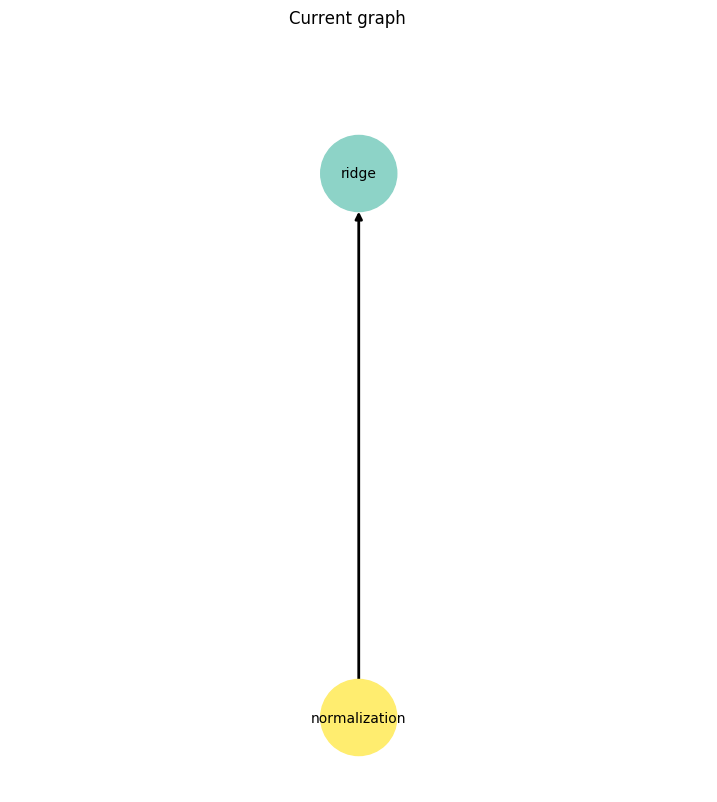

In [61]:
pipeline.show()

In [62]:
import matplotlib.pyplot as plt

In [63]:
pred = pipeline.predict(prepare_test_data, output_mode='full_probs')
pred

OutputData(idx=array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 17

In [64]:
pred = pred.predict
pred

array([[ 1.94755377e-07],
       [ 2.08408120e-07],
       [ 2.31585415e-07],
       [ 2.25800951e-06],
       [ 2.17143357e-07],
       [ 2.32698664e-07],
       [ 2.50171255e-07],
       [ 2.46718230e-08],
       [ 2.04544505e-07],
       [ 2.34386261e-07],
       [ 3.75789777e-09],
       [-4.30729965e-10],
       [ 2.33665021e-07],
       [ 2.33524972e-07],
       [ 2.39581575e-08],
       [ 2.32474428e-07],
       [ 2.32334523e-07],
       [ 2.16226128e-07],
       [ 3.91268542e-09],
       [ 1.81110433e-09],
       [ 7.76925874e-09],
       [ 4.69781190e-09],
       [ 2.34038913e-07],
       [ 2.59532759e-08],
       [ 1.11690443e-08],
       [ 2.47793765e-07],
       [ 2.33739294e-07],
       [ 2.44009857e-08],
       [ 2.32369300e-07],
       [ 2.43844189e-08],
       [ 2.25716085e-06],
       [ 2.27306031e-06],
       [ 2.47678846e-07],
       [ 2.47007285e-08],
       [ 1.99016955e-08],
       [ 2.45553666e-07],
       [ 2.42482099e-08],
       [ 6.46234882e-10],
       [ 1.9

In [66]:
from sklearn.metrics import *

MAE = mean_absolute_error(y_test_true, pred)
MSE = mean_squared_error(y_test_true, pred)
R2 = r2_score(y_test_true, pred)

print(f'MAE = {MAE}')
print(f'MSE = {MSE}')
print(f'R2 = {R2}')

MAE = 6.428847926090098e-07
MSE = 2.4971917947590842e-12
R2 = 0.21209030081424962


In [67]:
pipeline.save('milk_regression_fedot_ivium')

('{\n    "total_pipeline_operations": [\n        "normalization",\n        "ridge"\n    ],\n    "depth": 2,\n    "nodes": [\n        {\n            "operation_id": 1,\n            "operation_type": "normalization",\n            "operation_name": "NormalizationImplementation",\n            "custom_params": "default_params",\n            "params": "default_params",\n            "nodes_from": [],\n            "fitted_operation_path": [\n                "fitted_operations",\n                "operation_1.pkl"\n            ],\n            "rating": null\n        },\n        {\n            "operation_id": 0,\n            "operation_type": "ridge",\n            "operation_name": "Ridge",\n            "custom_params": {\n                "alpha": 2.443085127952943\n            },\n            "params": {\n                "alpha": 2.443085127952943\n            },\n            "nodes_from": [\n                1\n            ],\n            "fitted_operation_path": [\n                "fitted_opera